# Введение в GCNN. Message passing framework

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Курс "Машинное обучение на графах", Лекции 4-5 "Графовые нейронные сети"
* Документация:
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.triangles.html
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.eccentricity.html#networkx.algorithms.distance_measures.eccentricity
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html

* Дополнительные источники:
    * https://tkipf.github.io/graph-convolutional-networks/

## Вопросы для совместного обсуждения

1\. Обсудите общие принципы организации вычислений в MPF и его использование для построения графовых сверточных нейронных сетей.

In [ ]:
import torch as th

In [ ]:
A = th.tensor(
    [
        [0, 1, 1],
        [1, 0, 1],
        [1, 0, 1],
    ]
).float()

In [ ]:
X = th.tensor(
    [
        [1, 1],
        [2, 2],
        [3, 3],
    ]
).float()

In [ ]:
X.dtype

torch.float32

In [ ]:
(X[1] + X[2]), (X[0] + X[2]), (X[0] + X[2])

(tensor([5., 5.]), tensor([4., 4.]), tensor([4., 4.]))

In [ ]:
A @ X

tensor([[5., 5.],
        [4., 4.],
        [4., 4.]])

In [ ]:
A1 = th.tensor(
    [
        [0, .5, .5],
        [.5, 0, .5],
        [.5, 0, .5],
    ]
)

In [ ]:
A1 @ X

tensor([[2.5000, 2.5000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]])

In [ ]:
W = th.rand((2, 13))

X1 = (A1 @ X) @ W
X1.shape

torch.Size([3, 13])

In [ ]:
W2 = th.rand((13, 1))

X2 = (A1 @ X1) @ W2
X2.shape

torch.Size([3, 1])

In [ ]:
X

tensor([[1., 1.],
        [2., 2.],
        [3., 3.]])

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Загрузите граф из файла `karate.graphml`. Визуализируйте граф, раскрасив в цвета классов (атрибут `label` у узлов).

Получите невзвешенную матрицу смежности $\mathbf{A}$ в виде тензора `torch` и тензор меток для каждого узла. Выведите полученные тензоры на экран.

- [X] Проверено на семинаре

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
G = nx.read_graphml("karate.graphml")

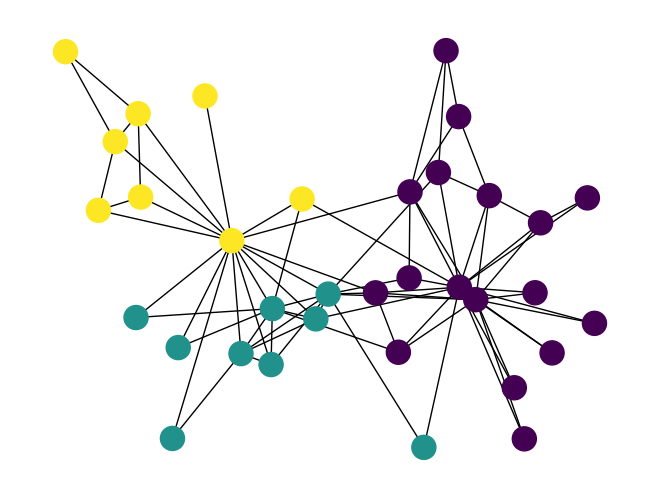

In [ ]:
nx.draw(G, node_color = list(dict(G.nodes(data='label')).values()))
plt.show()

In [ ]:
A = nx.adjacency_matrix(G, weight = None)
A_t = th.tensor(A.todense()).float()
A_t

tensor([[0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.]])

In [ ]:
labels = list(dict(G.nodes(data='label')).values())
labels_t = th.tensor(labels)
labels_t

tensor([2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

<p class="task" id="2"></p>

2\. Найдите стохастическую матрицу $\hat{\mathbf{A}}$.

$$\hat{\mathbf{A}} =\mathbf{D}^{-1}\mathbf{A}$$


Сгенерируйте тензор $\mathbf{X}$ размера `Nx5` с признаками узлов, используя `torch.rand`. Выполните один шаг рассылки сообщений при помощи матричного умножения.

$$\hat{\mathbf{X}} =\hat{\mathbf{A}}\mathbf{X}$$

Выполните этот же шаг рассылки сообщений, явно проитерировавшись по узлам графа и усреднив атрибуты соседей. Сравните два полученных тензора и покажите, что они равны.

Сделайте
- [X] Проверено на семинаре

In [ ]:
D = th.diag(th.sum(A_t, dim = 1)).float()

In [ ]:
A_t.dtype, D.dtype

(torch.float32, torch.float32)

In [ ]:
A_hat = th.inverse(D)@A_t

In [ ]:
A_hat

tensor([[0.0000, 0.0625, 0.0625,  ..., 0.0625, 0.0000, 0.0000],
        [0.1111, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.0000,  ..., 0.0000, 0.1000, 0.0000],
        ...,
        [0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.1667, 0.1667],
        [0.0000, 0.0000, 0.0833,  ..., 0.0833, 0.0000, 0.0833],
        [0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.0588, 0.0000]])

In [ ]:
X = th.rand(len(G), 5)

In [ ]:
X_hat = A_hat@X

In [ ]:
X_hat

tensor([[0.5349, 0.5291, 0.4828, 0.4909, 0.5724],
        [0.5872, 0.5402, 0.4583, 0.4576, 0.4951],
        [0.6189, 0.7044, 0.5768, 0.5344, 0.5432],
        [0.6214, 0.7395, 0.5847, 0.5497, 0.5427],
        [0.6516, 0.5636, 0.6528, 0.3577, 0.1626],
        [0.5262, 0.4427, 0.6209, 0.3761, 0.2140],
        [0.6488, 0.6066, 0.3570, 0.4591, 0.5917],
        [0.4280, 0.6497, 0.4444, 0.4552, 0.4443],
        [0.6653, 0.4445, 0.5315, 0.6150, 0.4605],
        [0.6973, 0.2840, 0.5280, 0.8750, 0.2165],
        [0.8151, 0.7822, 0.3010, 0.4682, 0.6661],
        [0.9593, 0.8287, 0.3233, 0.3453, 0.1577],
        [0.5366, 0.6567, 0.2389, 0.3187, 0.2942],
        [0.4967, 0.5558, 0.4309, 0.5609, 0.3660],
        [0.6607, 0.2182, 0.6409, 0.7408, 0.5037],
        [0.6607, 0.2182, 0.6409, 0.7408, 0.5037],
        [0.7249, 0.5941, 0.6646, 0.6206, 0.6086],
        [0.4875, 0.8632, 0.4721, 0.3812, 0.4832],
        [0.6607, 0.2182, 0.6409, 0.7408, 0.5037],
        [0.5821, 0.6355, 0.4403, 0.5821, 0.3397],


In [ ]:
X_hat1 = th.zeros_like(X)

In [ ]:
for i, node in enumerate(G.nodes()):
    neighbors = list(G.neighbors(node))
    neighbor_features = th.stack([X[int(j)] for j in neighbors])
    X_hat1[i] = th.mean(neighbor_features, dim=0)


In [ ]:
th.allclose(X_hat, X_hat1)


True

<p class="task" id="3"></p>

3\. Опишите слой `GCNLayer` графовой сверточной нейронной сети. Создайте слой с `n_outputs=3` и пропустите через этот слой матрицу смежности графа и тензор признаков  $\mathbf{X} = \mathbf{E}$. Выведите форму полученного тензора на экран.

- [X] Проверено на семинаре

In [ ]:
import torch.nn as nn
import torch as th

class GCNLayer(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, activation = None) -> None:
        super().__init__()

        # self.W - веса слоя
        W = th.empty(n_inputs, n_outputs, dtype=th.float32)
        nn.init.xavier_uniform_(W)
        self.W = nn.Parameter(W, requires_grad=True)

        # self.activation - функция активации, применяется после рассылки сообщений, может отсутствовать
        self.activation = activation

    def normalize_matrix(self, A: th.Tensor) -> th.Tensor:
        """A - исходная матрица смежности графа"""
        pass


    def forward(self, A: th.Tensor, X: th.Tensor) -> th.Tensor:
        """A - исходная матрица смежности графа
        X - матрица признаков узлов
        """
        pass

In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, activation = None) -> None:
        super().__init__()

        W = th.empty(n_inputs, n_outputs, dtype=th.float32)
        nn.init.xavier_uniform_(W)
        self.W = nn.Parameter(W, requires_grad=True)

        self.activation = activation

    def normalize_matrix(self, A: th.Tensor) -> th.Tensor:
        D = th.diag(th.sum(A, dim=1)).float()
        A_hat = th.inverse(D)@A_t
        return A_hat

    def forward(self, A: th.Tensor, X: th.Tensor) -> th.Tensor:
        A_hat = self.normalize_matrix(A)
        X_hat = A_hat @ X
        Z = X_hat @ self.W
        if self.activation:
            Z = self.activation(Z)
        return Z


In [ ]:
E = th.eye(A_t.shape[0])

In [ ]:
gcn = GCNLayer(n_inputs=E.shape[0], n_outputs=3)

In [ ]:
output = gcn(A_t, E)

In [ ]:
output.shape

torch.Size([34, 3])

In [ ]:
E.shape

torch.Size([34, 34])

In [ ]:
X.shape[0]

34

<p class="task" id="4"></p>

4\. Используя графовую сверточную нейронную сеть, решите задачу классификации узлов. Создайте модель, состоящую из двух последовательно идущих слоев `GCNLayer`. Первый слой имеет 2 нейрона и гиперболический тангенс в качестве функции активации. Количество нейронов во втором слое определяется количеством классов в задаче. Настройте модель (в качестве признаков узлов используйте единичную матрицу $\mathbf{X} = \mathbf{E}$).

После завершения процесса обучения пропустите данные через первый слой и визуализируйте граф, используя полученные векторные представления в качестве координат. Раскрасьте узлы в цвет соответствующих классов.

- [X] Проверено на семинаре

In [ ]:
class Net(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes):
        super().__init__()
        self.layer1 = GCNLayer(n_inputs=n_inputs, n_outputs=n_hidden, activation=th.tanh)
        self.layer2 = GCNLayer(n_inputs=n_hidden, n_outputs=n_classes)

    def forward(self, A, X):
        X = self.layer1(A, X)
        X = self.layer2(A, X)
        return X

In [ ]:
model = Net(E.shape[0], 2, 3)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(500):
    optimizer.zero_grad()
    output = model(A_t, E)
    loss = criterion(output, labels_t)
    loss.backward()
    optimizer.step()

In [ ]:
coords = model.layer1(A_t, E).detach().numpy()

In [ ]:
pos = {str(node):coord for node,coord in enumerate(coords)}

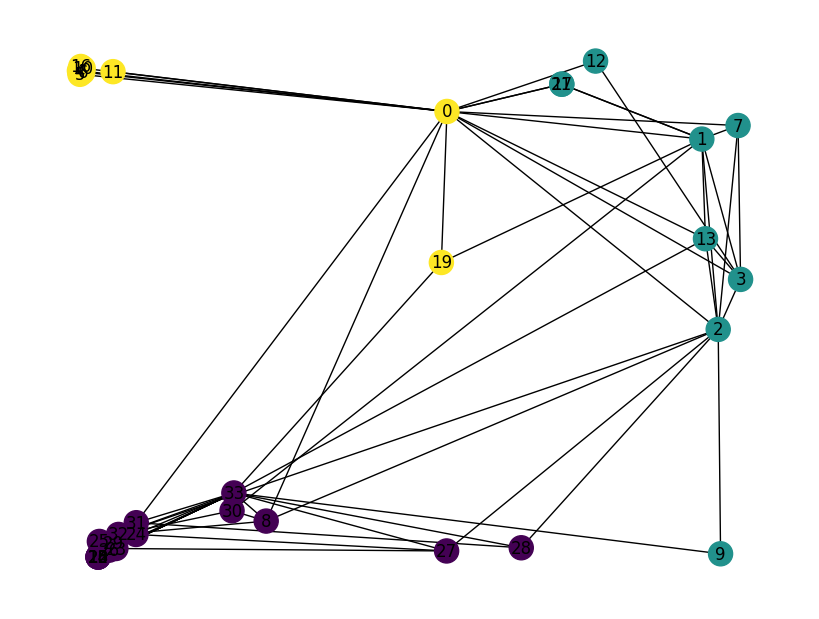

In [ ]:
plt.figure(figsize=(8, 6))
nx.draw(G, pos=pos, node_color = list(dict(G.nodes(data='label')).values()), with_labels=True)
plt.show()


In [ ]:
G.nodes()

NodeView(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33'))

<p class="task" id="5"></p>

5\. Повторите решение предыдущей задачи, используя в качестве признаков $\mathbf{X}$ следующие характеристики узлов:
* количество треугольников, в которые входит узел;
* степень узла;
* эксцентриситет узла;
* центральность по собственному вектору для узла.

Для ускорения процесса обучения стандартизуйте тензор признаков.


- [X] Проверено на семинаре

In [ ]:
triangles = nx.triangles(G)
degree = dict(G.degree())
eccentr = nx.eccentricity(G)
eig_centr = nx.eigenvector_centrality_numpy(G)

In [ ]:
X = th.tensor([
    [triangles[node], degree[node], eccentr[node], eig_centr[node]]
    for node in G.nodes()], dtype=th.float)


In [ ]:
mean = X.mean(dim=0)
std = X.std(dim=0)
X = (X - mean) / std


In [ ]:
X

tensor([[ 2.9728,  2.9428, -1.4355,  2.3065],
        [ 1.7014,  1.1377, -1.4355,  1.3188],
        [ 1.4895,  1.3956, -1.4355,  1.8840],
        [ 1.2776,  0.3641, -1.4355,  0.7145],
        [-0.4176, -0.4096, -0.0410, -0.7771],
        [-0.2057, -0.1517, -0.0410, -0.7383],
        [-0.2057, -0.1517, -0.0410, -0.7383],
        [ 0.4300, -0.1517, -0.0410,  0.2708],
        [ 0.2181,  0.1062, -1.4355,  0.8935],
        [-0.8414, -0.6674, -0.0410, -0.4825],
        [-0.4176, -0.4096, -0.0410, -0.7771],
        [-0.8414, -0.9253, -0.0410, -1.0321],
        [-0.6295, -0.6674, -0.0410, -0.6857],
        [ 0.4300,  0.1062, -1.4355,  0.8832],
        [-0.6295, -0.6674,  1.3535, -0.4965],
        [-0.6295, -0.6674,  1.3535, -0.4965],
        [-0.6295, -0.6674,  1.3535, -1.3544],
        [-0.6295, -0.6674, -0.0410, -0.5958],
        [-0.6295, -0.6674,  1.3535, -0.4965],
        [-0.6295, -0.4096, -1.4355,  0.0166],
        [-0.6295, -0.6674,  1.3535, -0.4965],
        [-0.6295, -0.6674, -0.0410

In [ ]:
model = Net(X.shape[1], 2, 3)
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(400):
    optimizer.zero_grad()
    output = model(A_t, X)
    loss = criterion(output, labels_t)
    loss.backward()
    optimizer.step()

In [ ]:
coords = model.layer1(A_t, X).detach().numpy()

In [ ]:
pos = {str(node):coord for node,coord in enumerate(coords)}

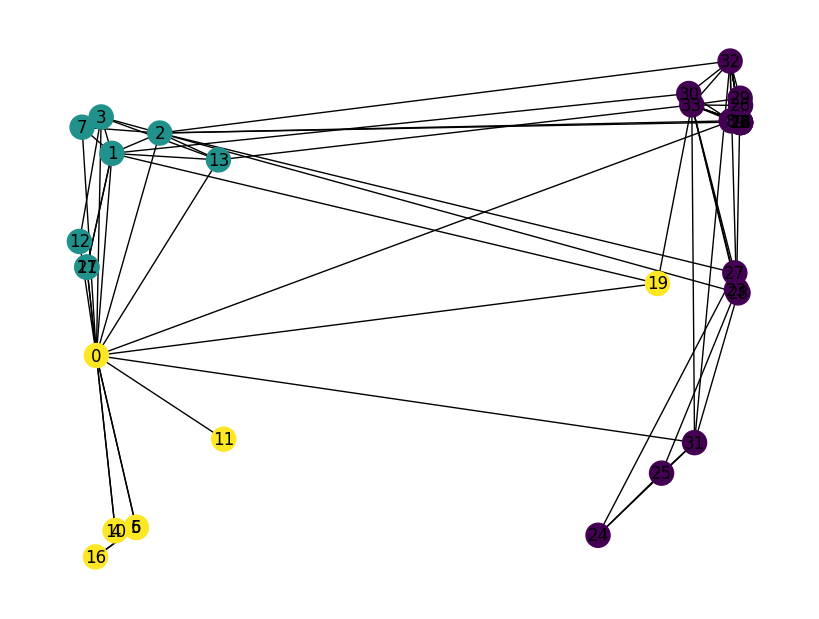

In [ ]:
plt.figure(figsize=(8, 6))
nx.draw(G, pos=pos, node_color = list(dict(G.nodes(data='label')).values()), with_labels=True)
plt.show()
